In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
NUMERICAL_COLS = ()
CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

### BaggedTreeClassifier

In [7]:
class BaggedTreeClassifier:
    def __init__(self, n_estimators, max_depth=None):
        self.B = n_estimators
        self.max_depth = max_depth

    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]

            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(Xb, Yb)
            self.models.append(model)

    def predict(self, X):
        # no need to keep a dictionary since we are doing binary classification
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return np.round(predictions / self.B)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(Y == P)

In [8]:
class DataTransformer:
    def fit(self, df):
        self.labelEncoders = {}
        self.scalers = {}
        
        # numerical
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].reshape(-1, 1))
            self.scalers[col] = scaler
            
        # categorical
        for col in CATEGORICAL_COLS:
            encoder = LabelEncoder()
            
            # in case the train set does not have 'missing value but test set does
            values = df[col].tolist()
            values.append('missing')
            encoder.fit(values)
            self.labelEncoders[col] = encoder
            
        # find dimensionality
        self.D = len(NUMERICAL_COLS)
        for col, encoder in self.labelEncoders.items():
            self.D += len(encoder.classes_)
        print("dimensionality: ", self.D)
        
    def transform(self, df):
        N, _ = df.shape
        X = np.zeros((N, self.D))
        i = 0
        
        # put data in X
        for col, scaler in self.scalers.items():
            X[:,i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            i += 1
        
        for col, encoder in self.labelEncoders.items():
            K = len(encoder.classes_)
            X[np.arange(N), encoder.transform(df[col]) + i] = 1
            i += K
        return X
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)
    
def replace_missing(df):
    # standard method of replacement for numerical columns is median
    
    for col in NUMERICAL_COLS:
        if np.any(df[col].isnull()):
            # median replacing
            med = np.median(df[col][df[col].notnull()])
            df.loc[df[col].isnull(), col] = med
            
    # set a special value = 'missing'
    for col in CATEGORICAL_COLS:
        if np.any(df[col].isnull()):
            print(col)
            df.loc[df[col].isnull(), col] = 'missing'
            
def get_data():
    df = pd.read_csv('./agaricus-lepiota.data.txt', header=None)
       
    # replace label column: e/p --> 0/1
    df[0] = df.apply(lambda row: 0 if row[0] =='e' else 1, axis=1)
    
    # missing data
    replace_missing(df)

    # transform data
    transformer = DataTransformer()
    
    X = transformer.fit_transform(df)
    Y = df[0].as_matrix()
    return X, Y

### Get Data

In [9]:
X, Y = get_data()
Ntrain = int(0.8*len(X))
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

dimensionality:  139


/Users/sailyourlife/anaconda3/envs/nextopt/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Build Not Random Forest

- 계속해서 features들의 sub feature로 feature로 매 노드에서 decision tree를 만든다.

In [10]:
class NotRandomForest:
    def __init__(self, n_estimators):
        self.B = n_estimators
        
    def fit(self, X, Y, M=None):
        N, D = X.shape
        if M is None:
            M = int(np.sqrt(D)) # feature 
            
        self.models = []
        self.features = []
        
        for b in range(self.B):
            tree = DecisionTreeClassifier()
            
            # sample features
            features = np.random.choice(D, size=M, replace=False)
            
            # sample training samples - bootstrap
            idx  = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]
            
            # 하나의 tree가 선택된 feature에 대해서 fit한다.
            tree.fit(Xb[:, features], Yb)
            self.features.append(features)
            self.models.append(tree)
            
    def predict(self, X):
        N = len(X)
        P = np.zeros(N)
        
        for features, tree in zip(self.features, self.models):
            P += tree.predict(X[:, features])
        return np.round(P / self.B)
    
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)            

In [13]:
T = 100
test_error_prf = np.empty(T)
test_error_rf = np.empty(T)
test_error_bag = np.empty(T)

for num_trees in range(T):
    if num_trees == 0:
        test_error_prf[num_trees] = None
        test_error_rf[num_trees] = None
        test_error_bag[num_trees] = None
    else:
        rf = RandomForestClassifier(n_estimators=num_trees)
        rf.fit(Xtrain, Ytrain)
        test_error_rf[num_trees] = rf.score(Xtest, Ytest)

        bg = BaggedTreeClassifier(n_estimators=num_trees)
        bg.fit(Xtrain, Ytrain)
        test_error_bag[num_trees] = bg.score(Xtest, Ytest)

        prf = NotRandomForest(n_estimators=num_trees)
        prf.fit(Xtrain, Ytrain)
        test_error_prf[num_trees] = prf.score(Xtest, Ytest)

    if num_trees % 10 == 0:
        print("num_trees:", num_trees)

num_trees: 0
num_trees: 10
num_trees: 20
num_trees: 30
num_trees: 40
num_trees: 50
num_trees: 60
num_trees: 70
num_trees: 80
num_trees: 90


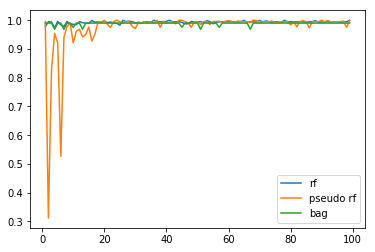

In [14]:
plt.plot(test_error_rf, label='rf')
plt.plot(test_error_prf, label='pseudo rf')
plt.plot(test_error_bag, label='bag')
plt.legend()
plt.show()